In [107]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import keras
from keras.layers import Dense,Dropout,GlobalAveragePooling2D,BatchNormalization
from keras import Sequential
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator,img_to_array,load_img
from keras.models import *
from PIL import Image
from keras import optimizers
import matplotlib.pyplot as plt
import seaborn as sns
import gc
from tqdm.notebook import tqdm

import os
%matplotlib inline

In [41]:
print(keras.__version__)

2.4.3


In [42]:
# Parameters for training
epochs = 20
num_epochs=5
batch_size = 8

In [43]:
# path 입력
train_dir = '../input/intel-image-classification/seg_train/seg_train/'
test_dir = '../input/intel-image-classification/seg_test/seg_test/'
pred_dir = '../input/intel-image-classification/seg_pred/seg_pred/'

In [44]:
#디렉토리 내부 살펴보기
os.listdir(train_dir)

['mountain', 'street', 'buildings', 'sea', 'forest', 'glacier']

In [77]:
# Parameters for training
epochs = 20
num_epochs=5
batch_size = 32

In [47]:
# path 입력
train_dir = '../input/intel-image-classification/seg_train/seg_train/'
test_dir = '../input/intel-image-classification/seg_test/seg_test/'
pred_dir = '../input/intel-image-classification/seg_pred/seg_pred/'

In [48]:
#디렉토리 내부 살펴보기
os.listdir(train_dir)

['mountain', 'street', 'buildings', 'sea', 'forest', 'glacier']

In [49]:
album = pd.DataFrame(columns = ["id","label"])
dirs = ['mountain', 'street', 'buildings', 'sea', 'forest', 'glacier']
# 각 디렉토리당 사진 정렬
for direc in dirs:
    #print(direc)
    for file in tqdm(os.listdir(train_dir + direc)):
        album = album.append({"id":file,"label":direc},ignore_index = True)
album.head()

,id,label
0,14986.jpg,mountain
1,3138.jpg,mountain
2,1700.jpg,mountain
3,16257.jpg,mountain
4,2863.jpg,mountain


In [50]:
#각 항목의 데이터의 수
album['label'].value_counts()

mountain     2512
glacier      2404
street       2382
sea          2274
forest       2271
buildings    2191
Name: label, dtype: int64

In [51]:
test_album = pd.DataFrame(columns = ["id","label"])
dirs = ['mountain', 'street', 'buildings', 'sea', 'forest', 'glacier']
# 테스트에 들어있는 사진 정렬
for direc in dirs:
    for file in os.listdir(test_dir + direc):
        test_album = test_album.append({"id":file,"label":direc},ignore_index = True)
test_album.head()

,id,label
0,22608.jpg,mountain
1,23274.jpg,mountain
2,23775.jpg,mountain
3,22046.jpg,mountain
4,23436.jpg,mountain


In [71]:
print(album.shape[0])
print(test_album.shape[0])

14034
3000


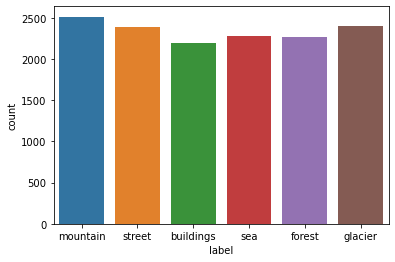

In [53]:
# train디고렉토리 내부 각 항목별 갯수 이미지화해서 확인
sns.countplot(x="label", data=album)

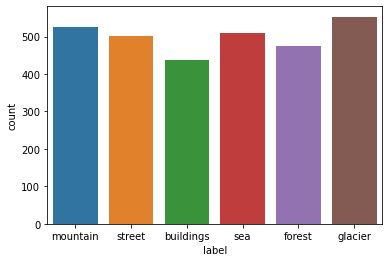

In [54]:
sns.countplot(x="label", data=test_album)

# See sample image

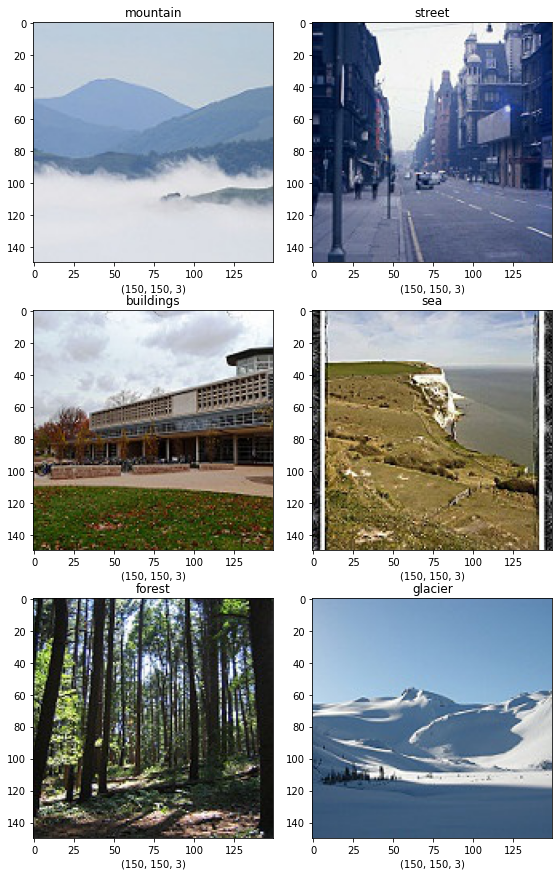

In [55]:
plt.figure(figsize = (10,15))
n = 0
# 항목들 이미지 보기
for label in dirs:
    n += 1
    # .where(a,b) : Replace values where the condition is False
    # a에는 조건을 넣어주고 그 조건이 안되는 값은 Nan값이 되거나 b로 값을 바꿈(b생략가능)
    # img는 (albun['id']에서 album['label']값이 lavel과 같지 않으면 Nan값이 됨 -> 난값은 dropna()으로 없어짐)의 0번째
    # 각 항목별로 하나씩만 가져오기 위해서
    img = (album["id"].where(album["label"] == label).dropna()).iloc[0]
    # 3열 2행으로 각자 1~6번째 자리로 순서대로 들어가게 된다
    plt.subplot(3,2,n)
    plt.subplots_adjust(hspace = 0.2,wspace = 0.001)
    path = train_dir + label + '/' + img
    plt.imshow(Image.open(path))
    # 파일의 가로,세로,채널 정보 기입
    plt.xlabel((img_to_array(Image.open(path))).shape)
    plt.title(label)
    
plt.show()

# 모델선언

In [56]:
# trans learning
from keras.applications import Xception

In [79]:
conv_base = Xception(weights='imagenet',
                  # include_top은 classifier를 포함하느냐 여부임
                  # False로 하니까 588MB가 불러와졌다 
                  # Total params: 16,812,353
                  include_top=False, 
                  input_shape=(150, 150, 3)) 
                  
                  
                  # True로 하면 528MB
                  #Total params: 138,614,057
                  #include_top=True, 
                  #input_shape=(224, 224, 3)) # classifier를 빼면 좀 더 가볍게 돌릴수 있다

83689472/83683744 [==============================] - 3s 0us/step


In [94]:
#STEP 1. 모델을 선언한다.
model = models.Sequential()

# CNN Feature Extractor
model.add(conv_base)

# CNN New Classifier
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(6, activation='softmax'))

In [95]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 5, 5, 2048)        20861480  
_________________________________________________________________
flatten_4 (Flatten)          (None, 51200)             0         
_________________________________________________________________
dense_8 (Dense)              (None, 128)               6553728   
_________________________________________________________________
dense_9 (Dense)              (None, 6)                 774       
Total params: 27,415,982
Trainable params: 6,554,502
Non-trainable params: 20,861,480
_________________________________________________________________


In [96]:
print('conv_base를 동결하기 전 훈련되는 가중치의 수:', 
      len(model.trainable_weights))

conv_base를 동결하기 전 훈련되는 가중치의 수: 4


In [97]:
conv_base.trainable = False

In [98]:
print('conv_base를 동결한 후 훈련되는 가중치의 수:', 
      len(model.trainable_weights))

conv_base를 동결한 후 훈련되는 가중치의 수: 4


In [99]:
def generate(train_dir,test_dir):
    # train data data augmentation
    train_datagen = ImageDataGenerator(rescale=1./255,horizontal_flip=True,validation_split = 0.2)
    # test data에는 augmentation을 하면 안된다
    test_datagen = ImageDataGenerator(rescale=1./255)
    
    # train data 설정
    train_gen = train_datagen.flow_from_directory(
      directory = train_dir,
      subset="training",
      target_size = (150,150),
      shuffle = True,
      class_mode = 'categorical',
      batch_size=32)
    
    # validation data 설정
    val_gen = train_datagen.flow_from_directory(
      directory = train_dir,
      subset="validation",
      shuffle = True,
      class_mode = 'categorical',
      target_size=(150,150),
      batch_size=32)
    
    # test data 설정
    test_gen = test_datagen.flow_from_directory(
      directory = test_dir,
      shuffle = True,
      class_mode = 'categorical',
      target_size = (150,150),
      batch_size = batch_size)
    
    return train_gen,val_gen,test_gen

In [100]:

train_gen,valid_gen,test_gen = generate(train_dir,test_dir)

Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


In [101]:
total_train = len(train_gen)
total_test = len(test_gen)
total_valid = len(valid_gen)


In [108]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])


history = model.fit_generator(
    train_gen, 
    epochs=7,
    validation_data=valid_gen,
    validation_steps=total_valid//batch_size,
    steps_per_epoch=total_train//batch_size,
    #callbacks=callbacks
)

Epoch 1/7
10/10 [==============================] - 3s 302ms/step - loss: 0.9761 - acc: 0.6469 - val_loss: 0.7061 - val_acc: 0.7500
Epoch 2/7
10/10 [==============================] - 2s 218ms/step - loss: 0.5843 - acc: 0.7937 - val_loss: 0.4447 - val_acc: 0.8281
Epoch 3/7
10/10 [==============================] - 2s 227ms/step - loss: 0.4049 - acc: 0.8969 - val_loss: 0.5374 - val_acc: 0.7812
Epoch 4/7
10/10 [==============================] - 2s 209ms/step - loss: 0.4610 - acc: 0.8438 - val_loss: 0.3608 - val_acc: 0.8125
Epoch 5/7
10/10 [==============================] - 2s 200ms/step - loss: 0.3522 - acc: 0.8750 - val_loss: 0.2681 - val_acc: 0.9062
Epoch 6/7
10/10 [==============================] - 2s 205ms/step - loss: 0.3958 - acc: 0.8500 - val_loss: 0.3201 - val_acc: 0.8906
Epoch 7/7
10/10 [==============================] - 2s 191ms/step - loss: 0.3039 - acc: 0.8906 - val_loss: 0.3612 - val_acc: 0.8750


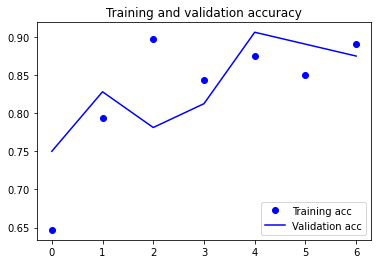

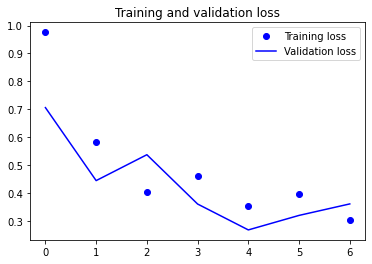

In [110]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [111]:

conv_base.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 74, 74, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 74, 74, 32)   0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [113]:

conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block14_sepconv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_gen,
      steps_per_epoch=100,
      epochs=100,
      validation_data=valid_gen,
      validation_steps=50)

Epoch 1/100
100/100 [==============================] - 25s 248ms/step - loss: 0.3849 - acc: 0.8725 - val_loss: 0.3324 - val_acc: 0.8906
Epoch 2/100
100/100 [==============================] - 17s 174ms/step - loss: 0.3012 - acc: 0.8897 - val_loss: 0.3131 - val_acc: 0.8888
Epoch 3/100
100/100 [==============================] - 14s 143ms/step - loss: 0.2711 - acc: 0.9040 - val_loss: 0.2799 - val_acc: 0.9075
Epoch 4/100
100/100 [==============================] - 12s 125ms/step - loss: 0.2523 - acc: 0.9134 - val_loss: 0.2792 - val_acc: 0.9025
Epoch 5/100
100/100 [==============================] - 12s 122ms/step - loss: 0.2485 - acc: 0.9069 - val_loss: 0.2821 - val_acc: 0.9025
Epoch 6/100
100/100 [==============================] - 11s 108ms/step - loss: 0.2286 - acc: 0.9191 - val_loss: 0.2585 - val_acc: 0.9075
Epoch 7/100
 47/100 [=============>................] - ETA: 3s - loss: 0.2090 - acc: 0.9229

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
def smooth_curve(points, factor=0.8):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

plt.plot(epochs,
         smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs,
         smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs,
         smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs,
         smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
test_loss, test_acc = model.evaluate_generator(test_gen, steps=50)
print('test acc:', test_acc)